# Build, Train and evaluate models with tensorflow decision forests

Decision Forests (df) are a large family of machine learning algorithms for superivsed classification, regression and ranking. They use decision trees as a building block.

today the two most popular df algorithms are random forests and gradient boosted decision trees. Both are ensemble tecniques that use multiple decision trees, but differ on how they do it

In this tutorial, you will learn how to:

1. Train a binary classification Random Forest on a dataset containing numerical, categorical  and missing features.
2. Evaluate the model on a test dataset.
3. Prepare the model for TensorFlow Serving.
4. Examine the overall structure of the model and the importance of each feature.
5. Re-train the model with a different learning algorithm (Gradient Boosted Decision Trees).
6. Use a different set of input features.
7. Change the hyperparameters of the model.
8. Preprocess the features.
9. Train a model for regression.
10. Train a model for ranking.

url: https://www.tensorflow.org/decision_forests/tutorials/beginner_colab

### Import libraries

In [1]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

In [2]:
# check version of the tensorflow df
print("Found tensorflow df v" + tfdf.__version__)

Found tensorflow df v1.0.1


## Training a Random Forest Model

We will train, evaluate, analyse and export binary classification Random Forest trained on the palmer penquins dataset


### Load the dataset and convert it in a tf.dataset

This dataset is small and stored as a csv-like file

Lets assemble the dataset into a csv file and load it

In [3]:
# load a dataset into pandas dataframe
fname = "../../dataset/penguins.csv"
dataset_df = pd.read_csv(fname)

# display the first 3 examples
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


Dataset conatain a mix of numerical (bill_depth_mm), categorical (island) and missing features.

TFDF supports all these feature types natively (differently than nn based models), therefore there is no need to preprocess in the form of one-hot encoding, normalization or extra is_present feature.

labels are a bit different. Keras metrics expect inegers. The label (species) is stored as a string so lets convert it into a integer 

### Encode the categorical labels as integers

This stage is necessary if your classification label is represented as a string since keras expect integer classification labels.

When using pd_dataframe_to_tf_dataset, this step can be skipped

In [4]:
# name of the label column
label = "species"

classes = dataset_df[label].unique().tolist()
print(f"label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

label classes: ['Adelie', 'Gentoo', 'Chinstrap']


In [5]:
dataset_df[label]

0      0
1      0
2      0
3      0
4      0
      ..
339    2
340    2
341    2
342    2
343    2
Name: species, Length: 344, dtype: int64

split the dataset into training and testing

In [6]:
# split the dataset into a training and testing dataset

def split_dataset(dataset, test_ratio=0.30):
    """Split a panda dataframe in two"""
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing" .format(
    len(train_ds_pd), len(test_ds_pd)
))

245 examples in training, 99 examples for testing


Finally convert the pandas dataframe (pd.dataframe) into tensorflow datasets (tf.data.dataset)

Notes: Recall that pd_dataframe_to_tf_dataset converts string labels to integers if necessary

In [7]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



/Users/eric/keras-env/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
2023-01-05 17:27:42.696229: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-05 17:27:42.697180: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/eric/keras-env/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the a

if you want to create the tf.data.dataset yourself, there are couple of things to remember:
- the learning algorithms work with a one-epoch dataset and without shuffling
- The batch size does not impact the training algorithm, but a small value might slow down reading the dataset

## Train the model

In [8]:
# specify the model
model_1 = tfdf.keras.RandomForestModel(verbose=2)

# train the model
model_1.fit(x=train_ds)

Use 8 thread(s) for training
Use /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmpj_34xp56 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'island': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>, 'bill_length_mm': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'bill_depth_mm': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'flipper_length_mm': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'body_mass_g': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'sex': <tf.Tensor 'data_5:0' shape=(None,) dtype=string>, 'year': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>}
Label: Tensor("data_7:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'island': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_4:0' shape=(None,) dtype=string>), 'bill_length_mm': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'bill_depth_

2023-01-05 17:27:44.723356: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 17:27:44.724624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training dataset read in 0:00:02.004484. Found 245 examples.
Training model...
Standard output detected as not visible to the user e.g. running in a notebook. Creating a training log redirection. If training get stuck, try calling tfdf.keras.set_training_logs_redirection(False).


[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 1
[INFO kernel.cc:423] Number of examples: 245
[INFO kernel.cc:836] Training dataset:
Number of records: 245
Number of columns: 8

Number of columns by type:
	NUMERICAL: 5 (62.5%)
	CATEGORICAL: 3 (37.5%)

Columns:

NUMERICAL: 5 (62.5%)
	0: "bill_depth_mm" NUMERICAL num-nas:2 (0.816327%) mean:17.0259 min:13.1 max:21.2 sd:2.00851
	1: "bill_length_mm" NUMERICAL num-nas:2 (0.816327%) mean:43.8519 min:33.1 max:55.9 sd:5.45334
	2: "body_mass_g" NUMERICAL num-nas:2 (0.816327%) mean:4218.11 min:2700 max:6000 sd:798.243
	3: "flipper_length_mm" NUMERICAL num-nas:2 (0.816327%) mean:201.605 min:172 max:231 sd:13.8787
	6: "year" NUMERICAL mean:2008.06 min:2007 max:2009 sd:0.816163

CATEGORICAL: 3 (37.5%)
	4: "island" CATEGORICAL has-dict vocab-size:4 zero-ood-items most-frequent:"Biscoe" 126 (51.4286%)
	5: "sex" CATEGORICAL num-nas:9 (3.67347%) has-dict vocab-si

Model trained in 0:00:00.058911
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


2023-01-05 17:27:45.736857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-05 17:27:45.879238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### Remarks

- No input featuers are specified. Therefore all the columsn will be used as input features expect for the label. The feature used by the model are shown in the training logs and in the model.summary()
- df consume natively numerical, categorical, categorical-set features and missing-value. Numerical features do not need to be normalized. Categorical strings values do not need to be encoded in a dictionary
- No training hyper parameters are specified. Therefore the default hyper-parameters will be used. Default hyper-parameters provide reasonable results in most situations
- Calling compile on the model before fit is optional. Compile can be used to provide extra evaluation metrics
- training algorithms do not need validation datatsets. If validation dataset is provided, it will not only be used to show metrics 
- tweak the verbose argument to radnomforestmodel to control the amount of displayed training logs. Set verbose=0 to hide most of the logs. Set verbose=2 to show all the logs

## Evaluate the model

Lets evaluate our model on the test dataset

In [9]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

2023-01-05 17:27:46.070661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 518ms/step - loss: 0.0000e+00 - accuracy: 0.9798

loss: 0.0000
accuracy: 0.9798


## Prepare this model for tensorflow serving

Export the model to savedmodel format for later reuse

In [10]:
model_1.save("../../saved-model/my_saved_model")

INFO:tensorflow:Assets written to: ../../saved-model/my_saved_model/assets


INFO:tensorflow:Assets written to: ../../saved-model/my_saved_model/assets


## Plot the model

Plotting a decision tree and following the first branches help learning about decision forests. In some cases, plotting a model can even be used for debugging.


Because of noise injected during training and depth of the trees, plotting random forest is less informative than plotting a cart or the first tree of a gradient boosted tree

In [11]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

## Model structure and feature importance

Overall structure of a model is show with summary()
- type
- task
- input features
- variables importance
- out of bag evaluation
- number of {trees, nodes} and other metrics

In [12]:
model_1.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	bill_depth_mm
	bill_length_mm
	body_mass_g
	flipper_length_mm
	island
	sex
	year

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.           "__LABEL"  3.036812 ################
    2.              "year"  3.007222 ###############
    3.               "sex"  2.993782 ###############
    4.       "body_mass_g"  2.497959 ###########
    5.            "island"  2.185907 ########
    6.     "bill_depth_mm"  1.910535 ######
    7.    "bill_length_mm"  1.456330 ##
    8. "flipper_length_mm"  1.202206 

Variable Importance: NUM_AS_ROOT:
    1. "flipper_length_mm" 155.000000 ################
    2.     "bill_depth_mm" 79.000

information in summary are all available programmatically using the model inspector

In [13]:
# input features
model_1.make_inspector().features()

["bill_depth_mm" (1; #0),
 "bill_length_mm" (1; #1),
 "body_mass_g" (1; #2),
 "flipper_length_mm" (1; #3),
 "island" (4; #4),
 "sex" (4; #5),
 "year" (1; #6)]

In [14]:
# feature importances
model_1.make_inspector().variable_importances()

{'MEAN_MIN_DEPTH': [("__LABEL" (4; #7), 3.036811568061565),
  ("year" (1; #6), 3.0072216209716176),
  ("sex" (4; #5), 2.993782467532465),
  ("body_mass_g" (1; #2), 2.4979592352092355),
  ("island" (4; #4), 2.185907407407409),
  ("bill_depth_mm" (1; #0), 1.9105353535353544),
  ("bill_length_mm" (1; #1), 1.456330327080328),
  ("flipper_length_mm" (1; #3), 1.2022063492063497)],
 'NUM_NODES': [("bill_length_mm" (1; #1), 602.0),
  ("flipper_length_mm" (1; #3), 341.0),
  ("bill_depth_mm" (1; #0), 295.0),
  ("body_mass_g" (1; #2), 290.0),
  ("island" (4; #4), 206.0),
  ("sex" (4; #5), 28.0),
  ("year" (1; #6), 15.0)],
 'SUM_SCORE': [("flipper_length_mm" (1; #3), 24848.625181040727),
  ("bill_length_mm" (1; #1), 24545.809307089075),
  ("bill_depth_mm" (1; #0), 13325.892534606159),
  ("island" (4; #4), 7147.811264049262),
  ("body_mass_g" (1; #2), 3018.639404365793),
  ("sex" (4; #5), 199.14650428295135),
  ("year" (1; #6), 39.811143381521106)],
 'NUM_AS_ROOT': [("flipper_length_mm" (1; #3), 15

## model self evaluation

Training a TFDF models can self evaluate even if no validation dataset is provided to the fit() method. 

Model self evaluation is available with the inspector evaluation()

In [15]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=245, accuracy=0.963265306122449, loss=0.08037141521974486, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

## Plotting the training logs

training logs show the quality of the model according to the number of trees in the model. These logs are helpful to study the balance between model size and model quality

Logs are available 
1. Displayed in during training if fit() is wrapped with sys_pipes()
2. At the end of the model summary model.summary()
3. programmatically using the model inspector 
4. using tensorboard

In [16]:
model_1.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=88, accuracy=0.9545454545454546, loss=1.6383477991277522, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=240, accuracy=0.9416666666666667, loss=1.1009848909452558, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=245, accuracy=0.9510204081632653, loss=0.3807383793045063, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=245, accuracy=0.963265306122449, loss=0.09166535382368127, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=245, accuracy=0.9673469387755103, loss=0.08049118547719353, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=245, accuracy=0.9673469387755103, loss=0.07508520278699544, rmse=No

lets plot it

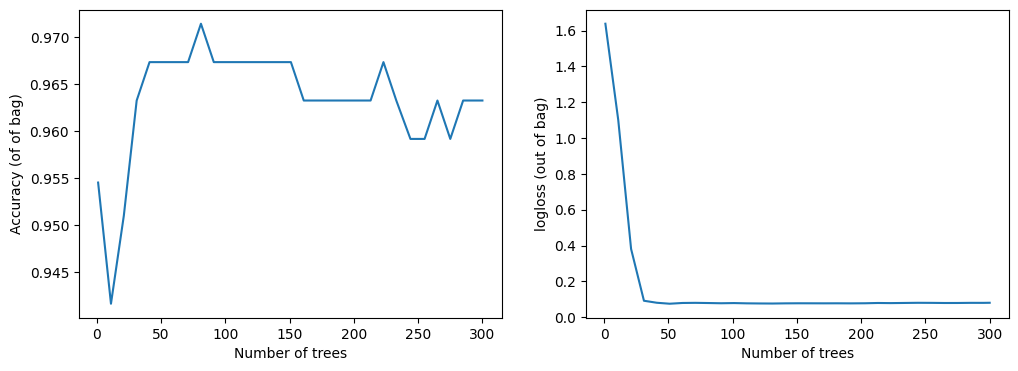

In [17]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (of of bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("logloss (out of bag)")

plt.show()


## Re-train the model with a different learning algorithm

Learning algorithm is defined by the model class. The learning algorithms are listed by calling tfdf.keras.get_all_models()

In [18]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

the description and the learning algorithms and their hyper-parameters are available

In [19]:
# help works anywhere
help(tfdf.keras.RandomForestModel)

# ? only works in ipython or notebooks
tfdf.keras.RandomForestModel?

Help on class RandomForestModel in module tensorflow_decision_forests.keras:

class RandomForestModel(tensorflow_decision_forests.keras.wrappers.RandomForestModel)
 |  RandomForestModel(*args, **kwargs)
 |  
 |  Random Forest learning algorithm.
 |  
 |  A Random Forest (https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)
 |  is a collection of deep CART decision trees trained independently and without
 |  pruning. Each tree is trained on a random subset of the original training 
 |  dataset (sampled with replacement).
 |  
 |  The algorithm is unique in that it is robust to overfitting, even in extreme
 |  cases e.g. when there is more features than training examples.
 |  
 |  It is probably the most well-known of the Decision Forest training
 |  algorithms.
 |  
 |  Usage example:
 |  
 |  ```python
 |  import tensorflow_decision_forests as tfdf
 |  import pandas as pd
 |  
 |  dataset = pd.read_csv("project/dataset.csv")
 |  tf_dataset = tfdf.keras.pd_dataframe_to_tf_datase

Init signature: tfdf.keras.RandomForestModel(*args, **kwargs)
Docstring:     
Random Forest learning algorithm.

A Random Forest (https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)
is a collection of deep CART decision trees trained independently and without
pruning. Each tree is trained on a random subset of the original training 
dataset (sampled with replacement).

The algorithm is unique in that it is robust to overfitting, even in extreme
cases e.g. when there is more features than training examples.

It is probably the most well-known of the Decision Forest training
algorithms.

Usage example:

```python
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Hyper-parameter tuning:

```python
import tensorflow_decision_forests as tfdf
import pandas as

## using a subset of features

Previous example did not specify the features, so all the columns were used as input feature 

The following example shows how to specify input features

In [20]:
feature_1 = tfdf.keras.FeatureUsage(name="bill_length_mm")
feature_2 = tfdf.keras.FeatureUsage(name="island")

all_features = [feature_1, feature_2]

# model is only trained with two features 
#  it will not be as good as the one trained on all features

model_2 = tfdf.keras.GradientBoostedTreesModel(
    features=all_features, exclude_non_specified_features=True
)

model_2.compile(metrics=["accuracy"])
model_2.fit(x=train_ds, validation_data=test_ds)

print(model_2.evaluate(test_ds, return_dict=True))

Use /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmpft9po7og as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093720. Found 245 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(99, shape=(), dtype=int32)
Validation dataset read in 0:00:00.117978. Found 99 examples.
Training model...
Model trained in 0:00:00.022396
Compiling model...


2023-01-05 17:27:47.768216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-05 17:27:47.887807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[INFO kernel.cc:1176] Loading model from path /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmpft9po7og/model/ with prefix e6eff3d1f1084004
[INFO decision_forest.cc:639] Model loaded with 6 root(s), 128 node(s), and 2 input feature(s).
[INFO kernel.cc:1022] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 58ms/step - loss: 0.0000e+00 - accuracy: 0.9495
{'loss': 0.0, 'accuracy': 0.9494949579238892}


2023-01-05 17:27:47.980445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-05 17:27:48.041804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-05 17:27:48.106095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


tf-df attaches a semantics to each feature. This semantics controls how the feature is used by the model. The following semantics are currently supported:

- numerical: generally fo quantities or counts with full ordering. Example, age of person, number of items in a bag
- categorical: Generally the type/class in finite set of possible values with ordering. For example, the color red in the set {red, blue, green}
- categorical-set: Set of categorical values. Great to represent tokenized text


This dataset doesnt contain such features. To demonstrate we will make the model treat the year as categorical feature

In [21]:
feature_1 = tfdf.keras.FeatureUsage(name="year", semantic=tfdf.keras.FeatureSemantic.CATEGORICAL)
feature_2 = tfdf.keras.FeatureUsage(name="bill_length_mm")
feature_3 = tfdf.keras.FeatureUsage(name="sex")
all_features = [feature_1, feature_2, feature_3]

model_3 = tfdf.keras.GradientBoostedTreesModel(features=all_features, exclude_non_specified_features=True)
model_3.compile(metrics=["accuracy"])

model_3.fit(x=train_ds, validation_data=test_ds)

Use /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmppdeuq9bf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115223. Found 245 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(99, shape=(), dtype=int32)
Validation dataset read in 0:00:00.103065. Found 99 examples.
Training model...


2023-01-05 17:27:48.230426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-05 17:27:48.343420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model trained in 0:00:00.063543
Compiling model...
Model compiled.


[INFO kernel.cc:1176] Loading model from path /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmppdeuq9bf/model/ with prefix c8ccbbc35ca94111
[INFO decision_forest.cc:639] Model loaded with 57 root(s), 2087 node(s), and 3 input feature(s).
[INFO kernel.cc:1022] Use fast generic engine
2023-01-05 17:27:48.482199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-05 17:27:48.546619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Hyper-parameters

hyper-parameters are parameters of training algorithm that impact the quality of final model. They are specified in the model class constructor. The list of hyper-parameters is visible with the question mark colab command

The default hyper parameters of each algorithm matches approximatively the initial publication paper. To ensure consistancy, new features and their matching hyper parameters are always disable by default 

Good idea to tune your hyper-parameters

In [22]:
# a classical but sligtly more complex model
model_6 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500, growing_strategy="BEST_FIRST_GLOBAL", max_depth=8
)
model_6.fit(x=train_ds)

Use /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmpjvvy4y97 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.186590. Found 245 examples.
Training model...


2023-01-05 17:27:48.754448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model trained in 0:00:00.411467
Compiling model...
Model compiled.


[INFO kernel.cc:1176] Loading model from path /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmpjvvy4y97/model/ with prefix 5c3cacb022f949cb
[INFO decision_forest.cc:639] Model loaded with 210 root(s), 10316 node(s), and 7 input feature(s).
[INFO kernel.cc:1022] Use fast generic engine
2023-01-05 17:27:49.252438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-05 17:27:49.270929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [23]:
# a more complex but possibly more accurate model
model_7 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=8,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM",
)
model_7.fit(x=train_ds)

Use /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmph6pc5qjs as temporary training directory
Reading training dataset...


2023-01-05 17:27:49.370016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training dataset read in 0:00:00.110224. Found 245 examples.
Training model...
Model trained in 0:00:03.868694
Compiling model...


[INFO kernel.cc:1176] Loading model from path /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmph6pc5qjs/model/ with prefix 798a3a2c57cf4f07
[INFO decision_forest.cc:639] Model loaded with 1500 root(s), 85184 node(s), and 7 input feature(s).
[INFO kernel.cc:1022] Use fast generic engine
2023-01-05 17:27:53.325905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model compiled.


2023-01-05 17:27:53.374482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Feature Preprocessing

Pre-processing features is somethimes necessary to consume signls with complex structures, to regualrize the model or to apply transfer learning.

Preprocessing can be done in one of three ways:
1. Preprocessing on the pandas dataframe. This solution is easy to impletement and generally suitable for experimentation. However pre-processing logic will not be exported in the model by model.save()
2. keras preprocessing: more complex then pandas. It is packaged in the model
3. Tensorflow feature columns: api is part of the tf estimator library (!= keras) and planned for deprecation

next example, preprocessing the body_mass_g featuer in body_mass_kg = body_mass_g / 1000. 

The bill_length_mm is consumed iwthout pre-processing. Note that monotronic transformations have generally no impact on decision forest models

In [24]:
body_mass_g = tf.keras.layers.Input(shape=(1,), name="body_mass_g")
body_mass_kg = body_mass_g / 1000.0

bill_length_mm = tf.keras.layers.Input(shape=(1,), name="bill_length_mm")

raw_inputs = {"body_mass_g": body_mass_g, "bill_length_mm": bill_length_mm}
processed_inputs = {"body_mass_kg": body_mass_kg, "bill_length_mm": bill_length_mm}

# "preprocessor" contains the preprocesssing logic
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

# model_4 contain both the pre-processing logic and the decision forest
model_4 = tfdf.keras.RandomForestModel(preprocessing=preprocessor)
model_4.fit(x=train_ds)

model_4.summary()

Use /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmp6xk4lfwk as temporary training directory
Reading training dataset...


/Users/eric/keras-env/lib/python3.8/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['island', 'bill_depth_mm', 'flipper_length_mm', 'sex', 'year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2023-01-05 17:27:53.527375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training dataset read in 0:00:00.175621. Found 245 examples.
Training model...
Model trained in 0:00:00.022813
Compiling model...


[INFO kernel.cc:1176] Loading model from path /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmp6xk4lfwk/model/ with prefix a19bb359790d4507
[INFO decision_forest.cc:639] Model loaded with 300 root(s), 5388 node(s), and 2 input feature(s).
[INFO kernel.cc:1022] Use fast generic engine


2023-01-05 17:27:53.658541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model compiled.
Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          {'body_mass_kg': (None,   0         
                             1),                                 
                              'bill_length_mm': (None            
                             , 1)}                               
                                                                 
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (2):
	bill_length_mm
	body_mass_kg

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.        "__LABEL"  3.772296 ################
    2.   "body_mass_kg"  1.063279 ####
    3. "bill_length_mm"  0.071418 

Variable Importance: NUM_AS_ROOT:
    1. "bill_length_mm" 281.000000 #########

2023-01-05 17:27:53.677358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
